# 프로젝트 설명

- Accuracy: 96.92%
- MIoU: 96.80
- F1 스코어: 0.705
- 활성화 함수 sigmoid
- binary_crossentropy 손실함수 적용
- 이미지 크기 512로 훈련
- train: 1799, val: 933, test: 항상 933
- epoch: 20


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 훈련 데이터 파일 압축풀기 (자신의 경로에 맞게 세팅 필요!)

In [5]:
!tar -xvf '/content/drive/MyDrive/train_images_labels_targets.tar' -C '/content/'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
train/targets/hurricane-florence_00000096_post_disaster_target.png
train/targets/socal-fire_00001135_post_disaster_target.png
train/targets/hurricane-michael_00000244_pre_disaster_target.png
train/targets/hurricane-harvey_00000436_post_disaster_target.png
train/targets/mexico-earthquake_00000055_post_disaster_target.png
train/targets/socal-fire_00001125_post_disaster_target.png
train/targets/socal-fire_00001049_pre_disaster_target.png
train/targets/hurricane-harvey_00000156_pre_disaster_target.png
train/targets/hurricane-michael_00000500_pre_disaster_target.png
train/targets/hurricane-harvey_00000329_post_disaster_target.png
train/targets/hurricane-harvey_00000406_pre_disaster_target.png
train/targets/hurricane-florence_00000304_post_disaster_target.png
train/targets/guatemala-volcano_00000026_post_disaster_target.png
train/targets/socal-fire_00000423_post_disaster_target.png
train/targets/socal-fire_00000878_pre_disaster_target.png
train/targets/soc

In [6]:
!ls train
# socal-fire_00001357_post_disaster_target.png
# socal-fire_00001357_pre_disaster_target.png

images	labels	targets


# 단일 사진 클래스 개수 확인

In [7]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

# 파일 경로(사진경로)
label_image_path = '/content/train/targets/guatemala-volcano_00000000_pre_disaster_target.png'

# 이미지 로드
label_image = Image.open(label_image_path)

# 이미지를 numpy 배열로 변환
label_image_array = np.array(label_image)

# 레이블 이미지의 고유값과 분포 시각화
unique, counts = np.unique(label_image_array, return_counts=True)

# 고유값 분포를 프린트
print("Unique pixel values in label image:", unique)
print("Counts for each value:", counts)


Unique pixel values in label image: [0 1]
Counts for each value: [1032725   15851]


In [8]:
input_dir = 'train/images'
target_dir = 'train/targets'
img_size = (512, 512)
num_classes = 1 # sigmoid 는 1로 설정해야한다
batch_size = 1

input_img_paths = sorted([ os.path.join(input_dir, fname)
                           for fname in os.listdir(input_dir)
                           if fname.endswith('pre_disaster.png')])

target_img_paths = sorted([ os.path.join(target_dir, fname)
                           for fname in os.listdir(target_dir)
                           if fname.endswith('pre_disaster_target.png')])

print(input_img_paths[7])

print(target_img_paths[7])

train/images/guatemala-volcano_00000013_pre_disaster.png
train/targets/guatemala-volcano_00000013_pre_disaster_target.png


In [9]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import PIL
from PIL import ImageOps

display(Image(filename=input_img_paths[7]))
img = ImageOps.autocontrast(load_img(target_img_paths[7]))
display(img)
# class0: black class1: white

Output hidden; open in https://colab.research.google.com to view.

## 데이터 전처리

In [10]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class xBD(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, datagen):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.datagen = datagen  # 데이터 증강을 위한 ImageDataGenerator 객체
        self.epoch = 0

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
      # 현재 에폭 번호와 배치 인덱스를 기반으로 시드 생성
      seed = np.random.randint(1, 1000) + idx + (self.epoch * 1000)

      i = idx * self.batch_size
      batch_input_img_paths = self.input_img_paths[i:i + self.batch_size]
      batch_target_img_paths = self.target_img_paths[i:i + self.batch_size]

      x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype='float32')
      y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype='uint8')

      for j, (input_path, target_path) in enumerate(zip(batch_input_img_paths, batch_target_img_paths)):
          input_img = load_img(input_path, target_size=self.img_size)
          target_img = load_img(target_path, target_size=self.img_size, color_mode='grayscale')

          # 이미지를 배열로 변환
          input_img = img_to_array(input_img)
          target_img = img_to_array(target_img)

          # 매 배치마다 다른 시드를 사용하여 이미지 증강 적용
          input_img = self.datagen.random_transform(input_img, seed=seed)
          target_img = self.datagen.random_transform(target_img, seed=seed)

          x[j] = input_img
          y[j] = target_img

      return x, y

    def on_epoch_end(self):
        self.epoch += 1  # 에폭이 끝날 때마다 에폭 번호 증가

# 이미지 데이터 증강을 위한 ImageDataGenerator 설정
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)



# 옵션 1. 훈련 데이터 50%만 쓸 경우

반드시 50% 또는 100% 코드 중 하나만 실행하세요!

아래의 코드를 실행하세요!


In [43]:
import random

val_samples = 500 # 검증용 데이터셋 500개
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

# input_img_paths랑 target_img_path 50%만 저장
input_img_paths = input_img_paths[:len(input_img_paths)//2]
target_img_paths = target_img_paths[:len(target_img_paths)//2]

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_gen = xBD(batch_size, img_size, train_input_img_paths, train_target_img_paths,datagen)
val_gen = xBD(batch_size, img_size, val_input_img_paths, val_target_img_paths,datagen)

In [44]:
print("Number of training input images:", len(train_input_img_paths))
print("Number of training target images:", len(train_target_img_paths))


Number of training input images: 899
Number of training target images: 899


In [11]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt

# 7번째 이미지의 경로 가져오기
input_img_path = train_input_img_paths[7]
target_img_path = train_target_img_paths[7]

# 원본 이미지 로드
input_img = load_img(input_img_path)
target_img = load_img(target_img_path, color_mode='grayscale')

# 원본 이미지를 배열로 변환
input_img_array = img_to_array(input_img)
target_img_array = img_to_array(target_img)

# 증강 적용
seed = random.randint(1, 1000)  # Seed for augmentation
augmented_input = datagen.random_transform(input_img_array, seed=seed)
augmented_target = datagen.random_transform(target_img_array, seed=seed)

# 이미지 표시
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(array_to_img(input_img_array))
ax[0, 0].set_title("Original Input Image")
ax[0, 1].imshow(array_to_img(augmented_input))
ax[0, 1].set_title("Augmented Input Image")
ax[1, 0].imshow(array_to_img(target_img_array), cmap='gray')
ax[1, 0].set_title("Original Target Image")
ax[1, 1].imshow(array_to_img(augmented_target), cmap='gray')
ax[1, 1].set_title("Augmented Target Image")
plt.show()


NameError: name 'train_input_img_paths' is not defined

# 옵션2. 훈련 데이터 100% 쓸 경우

반드시 50% 또는 100% 코드 중 하나만 실행하세요!

아래의 코드를 실행하세요!

In [12]:
import random

val_samples = 933 # 검증용 데이터셋 933개
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_gen = xBD(batch_size, img_size, train_input_img_paths, train_target_img_paths,datagen)
val_gen = xBD(batch_size, img_size, val_input_img_paths, val_target_img_paths,datagen)

## 모델 구성

이진 분류 (sigmoid 사용):

출력 채널 수: 1 (하나의 확률 출력으로, 해당 클래스에 속할 확률을 나타냄)
활성화 함수: sigmoid (0과 1 사이의 값으로 출력을 제한, 이 값이 0.5 이상이면 하나의 클래스로, 그렇지 않으면 다른 클래스로 분류)
이진 분류 (softmax 사용):

출력 채널 수: 2 (두 개의 클래스 각각에 대한 확률을 출력)
활성화 함수: softmax (각 출력값을 확률로 변환하여 모든 클래스에 대한 확률의 합이 1이 되도록 함)
다중 클래스 분류 (softmax 사용):

출력 채널 수: 클래스 수에 해당하는 수
활성화 함수: softmax (위와 동일)

In [13]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
  inputs = keras.Input(shape=img_size + (3,))

  x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  previous_block_activation = x

  for filters in [64, 128, 256]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = layers.Conv2D(filters, 1, strides=2, padding='same')(previous_block_activation)
    x = layers.add([x, residual])
    previous_block_activation = x

  for filter in [256, 128, 64, 32]:
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D(2)(x)

    residual = layers.UpSampling2D(2)(previous_block_activation)
    residual = layers.Conv2D(filters, 1, padding='same')(residual)
    x = layers.add([x, residual])
    previous_block_activation = x

  outputs = layers.Conv2D(num_classes, 3, activation='sigmoid', padding='same')(x)

  model = keras.Model(inputs, outputs)
  return model

model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 32)         0         ['batch_normalization[0][0

## 모델 컴파일 및 학습



In [14]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

class DisplayFirstBatchImages(Callback):
    def __init__(self, train_gen):
        super().__init__()
        self.train_gen = train_gen  # train_gen 인스턴스 저장

    def on_epoch_begin(self, epoch, logs=None):
        # 첫 번째 배치 데이터 가져오기
        x_batch, y_batch = self.train_gen[0]

        # 첫 번째 이미지 표시
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(x_batch[0].astype('uint8'))  # 입력 이미지
        ax[0].title.set_text('Epoch {} - Input'.format(epoch + 1))
        ax[1].imshow(y_batch[0].squeeze(), cmap='gray')  # 타깃 이미지
        ax[1].title.set_text('Epoch {} - Target'.format(epoch + 1))
        plt.show()


In [16]:
print(train_gen[0][0].shape)

(1, 512, 512, 3)


In [17]:
display_images_callback = DisplayFirstBatchImages(train_gen)

callbacks = [
    keras.callbacks.ModelCheckpoint('xbd_segmentation_v8_0_1.h5', save_best_only=True),
    display_images_callback  # 추가한 콜백
]
epochs = 20
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Output hidden; open in https://colab.research.google.com to view.

In [18]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

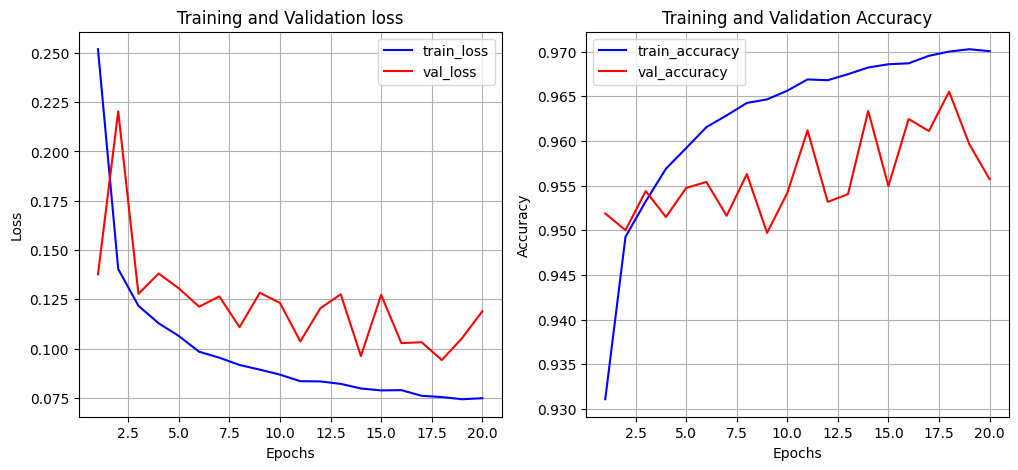

In [19]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')
ax1.set_title('Training and Validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']


ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, color='blue', label='train_accuracy')
ax2.plot(epochs, val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

<ipython-input-20-7319c479d1d2>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


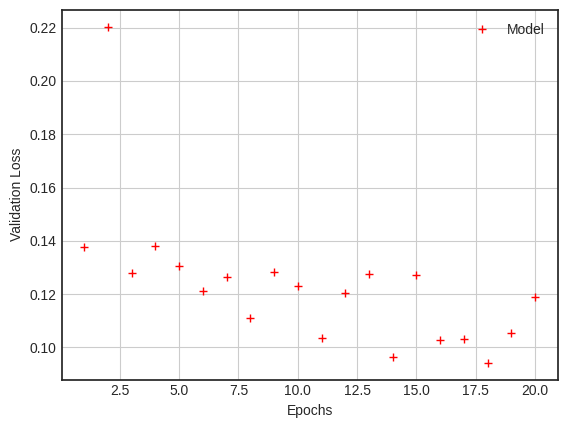

In [20]:
plt.style.use('seaborn-white')

plt.plot(epochs, val_loss, 'r+', label='Model')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid()
plt.show()

## 과소적합(Underfitting) / 과대적합(Overfitting)

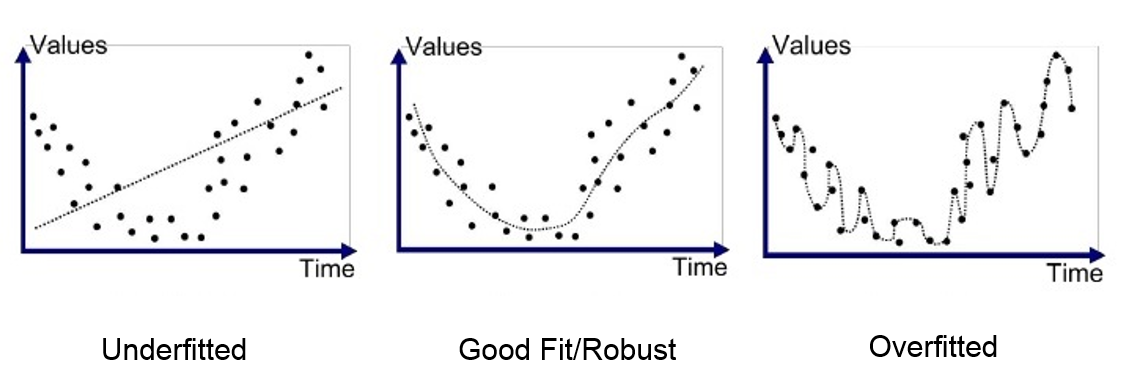

### 과소적합 (Underfitting)

- 학습 데이터를 충분히 학습하지 않아 성능이 매우 안 좋은 경우
- 모델이 지나치게 단순한 경우
- 해결 방안
  - 충분한 학습 데이터 수집
  - 보다 더 복잡한 모델 사용
  - 에폭수(epochs)를 늘려 충분히 학습

### 과대적합 (Overfitting)

- 모델이 학습 데이터에 지나치게 맞추어진 상태
- 새로운 데이터에서는 성능 저하
- 데이터에는 잡음이나 오류가 포함
- 학습 데이터가 매우 적을 경우
- 모델이 지나치게 복잡한 경우
- 학습 횟수가 매우 많을 경우
- 해결방안
  - 다양한 학습 데이터 수집 및 학습
  - 모델 단순화: 파라미터가 적은 모델을 선택하거나, 학습 데이터의 특성 수를 줄임
  - 정규화(Regularization)을 통한 규칙 단순화
  - 적정한 하이퍼 파라미터 찾기

### 과대적합(overfitting)과 과소적합(underfitting) 방지 방법

* 모델의 크기 축소
* 가중치 초기화(Weight Initializer)
* 옵티마이저(Optimizer)
* 배치 정규화(Batch Normalization)
* 규제화(Regularization)
* 드롭아웃(Dropout)

## 모델 평가 및 예측

In [21]:
from tensorflow import keras

class xBDt(keras.utils.Sequence):
  def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
    self.batch_size = batch_size
    self.img_size = img_size
    self.input_img_paths = input_img_paths
    self.target_img_paths = target_img_paths

  def __len__(self):
    return len(self.target_img_paths) // self.batch_size

  def __getitem__(self, idx):
    i = idx * self.batch_size
    batch_input_img_paths = self.input_img_paths[i:i+self.batch_size]
    batch_target_img_paths = self.target_img_paths[i:i+self.batch_size]
    x = np.zeros((self.batch_size, ) + self.img_size + (3, ), dtype='float32')
    for j, path in enumerate(batch_input_img_paths):
      img = load_img(path, target_size=self.img_size)
      x[j] = img
    y = np.zeros((self.batch_size, ) + self.img_size + (1, ), dtype='uint8')
    for j, path in enumerate(batch_target_img_paths):
      img = load_img(path, target_size=self.img_size, color_mode='grayscale')
      y[j] = np.expand_dims(img, 2)

    return x, y


In [22]:
from tensorflow.keras.models import load_model

# .h5 파일로부터 모델 로드
model = load_model('/content/xbd_segmentation_v8_0_1.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 32)         0         ['batch_normalization[0][0

In [23]:
!tar -xvf '/content/drive/MyDrive/test_images_labels_targets.tar' -C '/content/'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
test/labels/midwest-flooding_00000210_pre_disaster.json
test/labels/mexico-earthquake_00000080_pre_disaster.json
test/labels/socal-fire_00000558_pre_disaster.json
test/labels/hurricane-matthew_00000297_pre_disaster.json
test/labels/palu-tsunami_00000139_post_disaster.json
test/labels/hurricane-harvey_00000164_pre_disaster.json
test/labels/socal-fire_00000379_post_disaster.json
test/labels/socal-fire_00001222_post_disaster.json
test/labels/socal-fire_00000882_pre_disaster.json
test/labels/hurricane-matthew_00000076_pre_disaster.json
test/labels/socal-fire_00000823_pre_disaster.json
test/labels/hurricane-florence_00000005_pre_disaster.json
test/labels/socal-fire_00000646_post_disaster.json
test/labels/socal-fire_00001220_post_disaster.json
test/labels/hurricane-harvey_00000328_pre_disaster.json
test/labels/socal-fire_00000749_post_disaster.json
test/labels/hurricane-florence_00000253_pre_disaster.json
test/labels/socal-fire_00001240_pre_disaster.json
t

In [24]:
input_dir = 'test/images'
target_dir = 'test/targets'
img_size = (512, 512)
batch_size = 1

input_img_paths = sorted([ os.path.join(input_dir, fname)
                           for fname in os.listdir(input_dir)
                           if fname.endswith('pre_disaster.png')])

target_img_paths = sorted([ os.path.join(target_dir, fname)
                           for fname in os.listdir(target_dir)
                           if fname.endswith('pre_disaster_target.png')])

test_input_img_paths = input_img_paths
test_target_img_paths = target_img_paths

test_gen = xBDt(batch_size, img_size, test_input_img_paths, test_target_img_paths)

In [26]:
model.evaluate(test_gen)

933/933 [==============================] - 36s 38ms/step - loss: 0.0994 - accuracy: 0.9633


[0.09935776144266129, 0.9632986187934875]

In [25]:
import math

# 추론용 데이터 제너레이터 클래스 정의
class xBDInference(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths

    def __len__(self):
        return math.ceil(len(self.input_img_paths) / self.batch_size)

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i: i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype='float32')
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        return x


# 2. 테스트셋 이미지 모델 추론

In [27]:
test_gen = xBDInference(batch_size, img_size, test_input_img_paths)

test_preds = model.predict(test_gen)

933/933 [==============================] - 33s 35ms/step


In [28]:
from tensorflow.keras.preprocessing.image import array_to_img

def display_mask(i):
  mask = test_preds[i] > 0.5 # sigmoid 사용시
  img = PIL.ImageOps.autocontrast(array_to_img(mask))
  display(img)

# 예측 결과 출력
i = 12

display(Image(filename=test_input_img_paths[i]))
img = ImageOps.autocontrast(load_img(test_target_img_paths[i]))
display(img)
display_mask(i)


Output hidden; open in https://colab.research.google.com to view.

## xBD 테스트셋 데이터 추론 마스크 결과 사진 저장

In [29]:
# 저장할 폴더 경로
save_dir = "/content/drive/MyDrive/Colab_Notebooks/xBD/test_predicts_v8_1_0"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


In [30]:
def save_mask(i, input_img_paths, save_dir):
    # 입력 이미지 경로에서 파일 이름 추출
    original_filename = os.path.basename(input_img_paths[i])
    # 파일 확장자 제거
    filename_without_extension = os.path.splitext(original_filename)[0]

    # 추론한 마스크 생성
    mask = test_preds[i] > 0.5 # sigmoid 사용시
    img = ImageOps.autocontrast(array_to_img(mask))

    # 마스크를 저장할 파일 이름 설정 (원본 파일 이름에 '_mask' 추가)
    save_path = os.path.join(save_dir, f"{filename_without_extension}_mask.png")

    # 생성된 마스크를 지정된 폴더에 저장
    img.save(save_path)

    print(f"Mask saved at: {save_path}")

In [31]:
# test_preds에 저장된 모든 마스크에 대해 save_mask 함수를 호출하여 저장
for i in range(len(test_preds)):
    save_mask(i, test_input_img_paths, save_dir)

Mask saved at: /content/drive/MyDrive/Colab_Notebooks/xBD/test_predicts_v8_1_0/guatemala-volcano_00000003_pre_disaster_mask.png
Mask saved at: /content/drive/MyDrive/Colab_Notebooks/xBD/test_predicts_v8_1_0/guatemala-volcano_00000005_pre_disaster_mask.png
Mask saved at: /content/drive/MyDrive/Colab_Notebooks/xBD/test_predicts_v8_1_0/guatemala-volcano_00000009_pre_disaster_mask.png
Mask saved at: /content/drive/MyDrive/Colab_Notebooks/xBD/test_predicts_v8_1_0/guatemala-volcano_00000011_pre_disaster_mask.png
Mask saved at: /content/drive/MyDrive/Colab_Notebooks/xBD/test_predicts_v8_1_0/guatemala-volcano_00000021_pre_disaster_mask.png
Mask saved at: /content/drive/MyDrive/Colab_Notebooks/xBD/test_predicts_v8_1_0/hurricane-florence_00000004_pre_disaster_mask.png
Mask saved at: /content/drive/MyDrive/Colab_Notebooks/xBD/test_predicts_v8_1_0/hurricane-florence_00000005_pre_disaster_mask.png
Mask saved at: /content/drive/MyDrive/Colab_Notebooks/xBD/test_predicts_v8_1_0/hurricane-florence_0000

# MIOU 평가 (xBD test Data)



In [32]:
y_true_arrays = [load_img(path, target_size=img_size, color_mode='grayscale') for path in test_target_img_paths]
y_true = np.array([np.expand_dims(np.array(img), axis=-1) for img in y_true_arrays])
y_true = y_true.squeeze() # 필요시 차원 축소
# 예측 레이블 준비

# 예측 확률이 0.5 이상인 경우 1로, 그렇지 않으면 0으로 설정
y_pred = (test_preds.squeeze() > 0.5).astype(int)  # 예측 결과 이진화
#y_pred = np.argmax(test_preds, axis=-1)

# mIoU 계산
def mean_iou(y_true, y_pred, num_classes):
  intersection = np.zeros(num_classes)
  union = np.zeros(num_classes)
  for i in range(num_classes):
    intersection[i] = np.logical_and(y_true == i, y_pred == i).sum()
    union[i] = np.logical_or(y_true == i, y_pred == i).sum()
  iou = intersection / np.maximum(union, 1)
  mIoU = np.mean(iou)
  return mIoU

miou_score = mean_iou(y_true, y_pred, num_classes)
print("Mean IoU for the test set is:", miou_score)

Mean IoU for the test set is: 0.9620328410802993


# F1 스코어

In [33]:
from sklearn.metrics import f1_score

# 예측 레이블 준비 (이진 분류의 경우)
y_true_arrays = [load_img(path, target_size=img_size, color_mode='grayscale') for path in test_target_img_paths]
y_true = np.array([np.expand_dims(np.array(img), axis=-1) for img in y_true_arrays])
y_true = y_true.squeeze()  # 차원 축소, 결과는 0과 1의 레이블

# 예측 확률이 0.5 이상인 경우 1로, 그렇지 않으면 0으로 설정
y_pred = (test_preds.squeeze() > 0.5).astype(int)  # 예측 결과 이진화

# F1 스코어 계산
f1 = f1_score(y_true.flatten(), y_pred.flatten(), average='binary')  # 이진 분류

print("F1 Score for the test set is:", f1)


F1 Score for the test set is: 0.6449594532785992


# 결과

### accuracy: 96.92%
### MIOU: 96.80
### F1 Score: 0.705